<a href="https://colab.research.google.com/github/Ari-Net/ISPPR-2/blob/master/Lab-3_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
%load_ext tensorboard
from IPython.display import clear_output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
dir_alldata='/content/drive/MyDrive/dataset'
train_data_dir='/content/drive/MyDrive/dataset/train/'
validation_data_dir='/content/drive/MyDrive/dataset/val/'
test_data_dir='/content/drive/MyDrive/dataset/test/'
normal_cases_train='/content/drive/MyDrive/dataset/train/NORMAL'
pneumonia_cases_train='/content/drive/MyDrive/dataset/train/PNEUMONIA'

In [51]:
img_width, img_height = 150,150
nb_train_sample =1000
nb_validation_samples =100

epochs = 50
batch_size = 20

if K.image_data_format()=="channels_first":
    input_shape =(3,img_width, img_height)
else:
    input_shape =(img_width, img_height,3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator= train_datagen.flow_from_directory(train_data_dir, target_size =(150,150),batch_size=batch_size, class_mode="binary" )

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")
 
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")


Found 5256 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


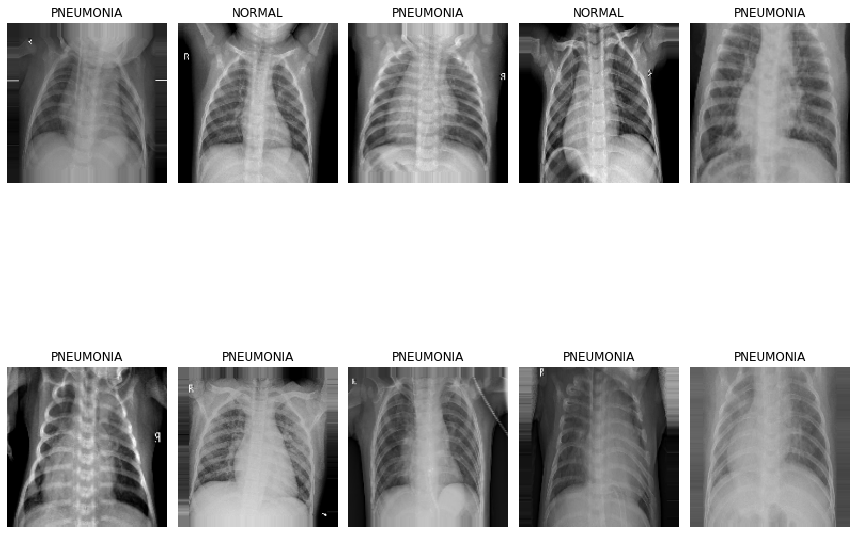

In [52]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [53]:
alexnet1 = Sequential()
alexnet1.add(Conv2D(filters=32,kernel_size=(3,3), strides=(1,1), input_shape=input_shape, activation="relu"))
alexnet1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
alexnet1.add(Conv2D(32,(3,3), strides=(1,1), input_shape=input_shape, activation="relu"))
alexnet1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
alexnet1.add(Conv2D(64,(3,3), strides=(1,1), input_shape=input_shape, activation="relu"))
alexnet1.add(Conv2D(64,(3,3), strides=(1,1),input_shape=input_shape, activation="relu"))
alexnet1.add(Conv2D(64,(3,3), strides=(1,1), input_shape=input_shape, activation="relu"))
alexnet1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
alexnet1.add(Flatten())
alexnet1.add(Dense(128, activation="relu"))
alexnet1.add(Dense(64, activation="relu"))
alexnet1.add(Dense(1, activation="sigmoid"))
alexnet1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 30, 30, 64)       

In [54]:
early = EarlyStopping(monitor="loss", mode="min", patience=3)

In [55]:
alexnet1.compile(loss= "binary_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics=[tf.keras.metrics.AUC(name='AUC'),"accuracy",F1Score(1,average='macro',name='f1')])

In [56]:
history = alexnet1.fit_generator(train_generator, steps_per_epoch=nb_train_sample//batch_size, epochs=epochs,validation_data=validation_generator, callbacks=[early, TensorBoard(log_dir="logs/AlexNet_1/")], validation_steps=nb_validation_samples//batch_size)
clear_output()
pd.Series({k:v[-1] for k, v in history.history.items()})

loss            0.560968
AUC             0.679228
accuracy        0.725000
f1              0.840580
val_loss        0.842572
val_AUC         0.421875
val_accuracy    0.500000
val_f1          0.666667
dtype: float64

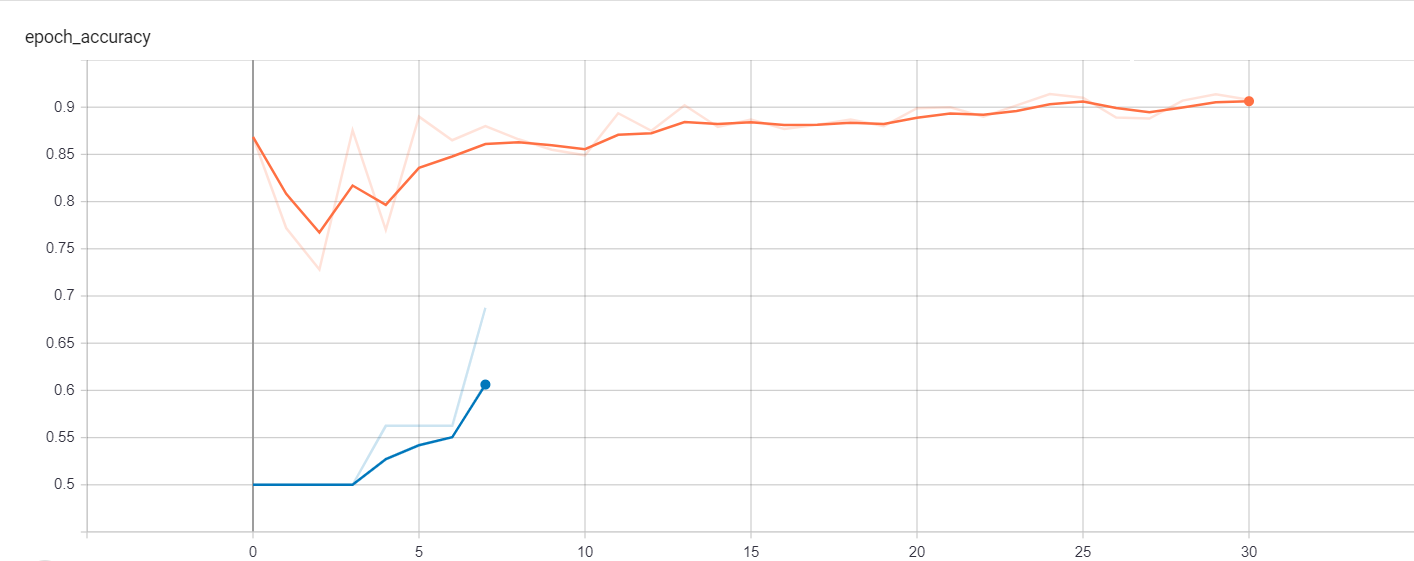


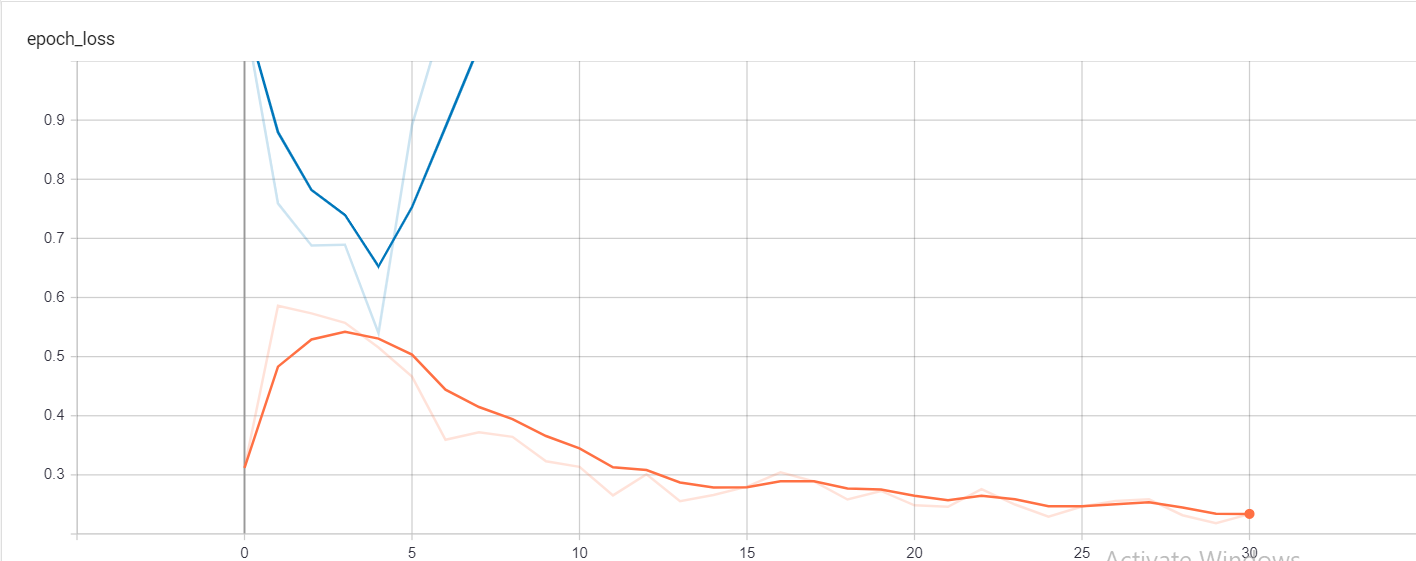

In [59]:
#!tensorboard dev upload --logdir /content/logs/ \